In [9]:
# Imports
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
import momepy as mp
import numpy as np
import rioxarray as rxr
import elevation
import rasterio
import numpy as np
import rasterio
from rasterio import transform
import pyproj

[-76.52659448  42.41822558 -76.47075525  42.46392551]
OBJECTID
NAME
ALTNAME
BLOCK
Location_n
Fromstreet
ToStreet
TOTALANES
DIRECT1
SIDEWLK1
WIDTH_C_C
WIDTHAPPRO
ROW_WIDTH
StateRte
FCLASS2014
STATERESP
OWNERSHIP
lengthinv
SURFACETXT
SHOULDTEXT
RESPONSERO
OWNTYPE
MGTRESPONB
STATEROUTE
DeedyrBkPg
SID
RINNUM
SHAPE__Len
geometry


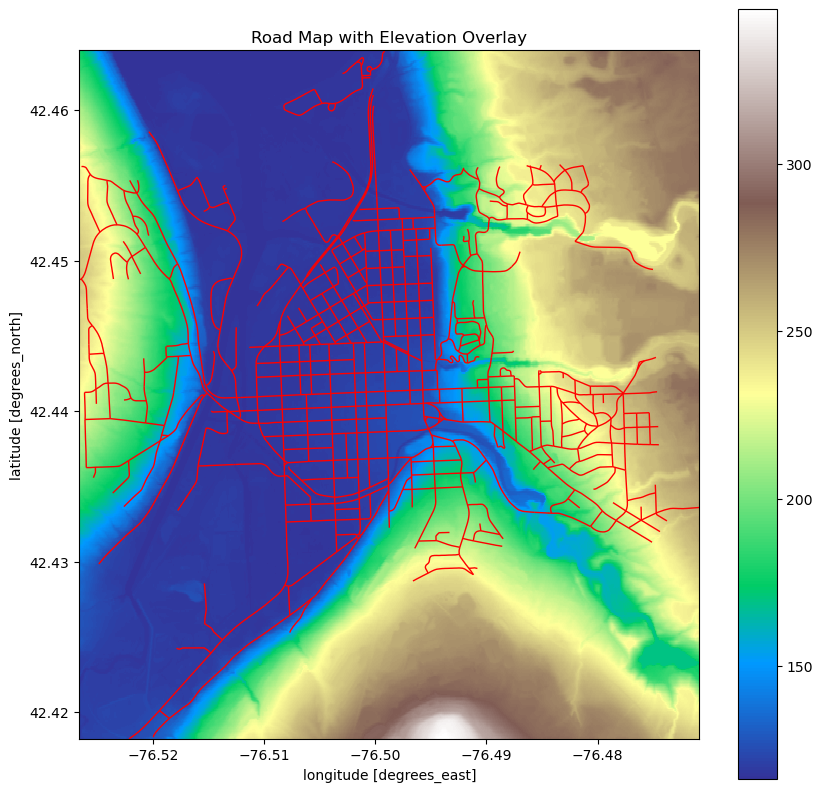

In [10]:
# File Loading

roads = gpd.read_file('./Roads/Roads.shp')

# Converting single line to multi line
roads = roads.explode(index_parts=False).reset_index(drop=True)

roads = roads[~roads["OWNERSHIP"].isin(["PRIVATE","CU"])]

# Loading elevation data:
roads = roads.to_crs("EPSG:4326")

bounds = roads.total_bounds
print(bounds)
for i in roads.columns:
    print(i)

dem = rxr.open_rasterio("./Elevation/10m_resolution_dem.tif", masked=True)

dem_clipped = dem.rio.clip_box(
    minx=bounds[0],
    miny=bounds[1],
    maxx=bounds[2],
    maxy=bounds[3]
)


fig, ax = plt.subplots(figsize=(10, 10))
dem_clipped.plot(ax=ax, cmap="terrain")
roads.plot(ax=ax, color="red", linewidth=1)
plt.title("Road Map with Elevation Overlay")
plt.show()


In [11]:
import numpy as np

def get_elevation_at_point(lon, lat, dem):
    # Use the rasterio transform to map lon/lat to row/col
    row, col = ~dem.rio.transform() * (lon, lat)
    
    row, col = int(row), int(col)
    
    # Clip to DEM bounds
    row = np.clip(row, 0, dem.shape[1] - 1)
    col = np.clip(col, 0, dem.shape[2] - 1)

    # Return the elevation value
    return float(dem.values[0, row, col])

# Example for a single line
line = roads.iloc[0].geometry
start, end = line.coords[0], line.coords[-1]

z_start = get_elevation_at_point(start[0], start[1], dem_clipped)
z_end = get_elevation_at_point(end[0], end[1], dem_clipped)

print(z_start, z_end)





116.08763122558594 117.31242370605469


In [12]:
# Mapping through all of the coords
def add_slope_to_roads(roads):
    slopes = []
    for i in range(len(roads)):
        line = roads.iloc[i].geometry
        start, end = line.coords[0], line.coords[-1]

        z_start = get_elevation_at_point(start[0], start[1], dem_clipped)
        z_end = get_elevation_at_point(end[0], end[1], dem_clipped)

        euclidean_distance = np.sqrt((end[1]-end[0])**2 + (start[1]-start[0])**2)
        slope = (z_end - z_start) / euclidean_distance

        slopes.append(np.abs(slope*100))

    roads["slope"] = slopes

    return roads


In [13]:
roads = add_slope_to_roads(roads)

for index, row in roads.iterrows():
    print(row['slope'])
    

    

0.7279565977682428
0.0
0.6842840765148034
0.8140712317889148
0.20825779672129455
2.047714481509123
0.0
0.0
1.363358954745259
0.5794052752305698
0.17691685998114373
0.4799720114871501
16.422727791384748
6.291585891310738
14.092974203239594
17.01660289459072
20.589512371899644
34.57269761365444
0.3072355676219969
0.052280922720813625
0.02119170989971379
0.11477593543760946
0.005039305849585749
0.16887429180097732
0.49637445809037417
0.043619094387420496
0.2113409792210856
0.44958929925436814
0.17009990583964674
6.141604749017173
23.58155192717821
18.478329869085957
26.03079487556222
20.291703394184182
6.313422199556077
0.29219218644463224
0.5110766194376372
0.4851357862262826
0.39644466305296855
0.6013795125961678
0.3492350836459959
0.2444860027624709
6.699855600268406
22.662634893987953
0.6604751051437215
0.3190187534523584
3.54839725561436
0.17930393678185036
0.1822618375148372
0.2139924408155409
1.5210053031579933
0.3611381334452827
1.2278946251828085
0.027420355586935233
1.1362787909

In [14]:
import numpy as np

def add_slope_categories(roads):
    roads['slope_below5']  = (roads['slope'] < 5).astype(int)
    roads['slope_5_10']    = ((roads['slope'] >= 5) & (roads['slope'] < 10)).astype(int)
    roads['slope_10_15']   = ((roads['slope'] >= 10) & (roads['slope'] < 15)).astype(int)
    roads['slope_above15'] = (roads['slope'] >= 15).astype(int)

add_slope_categories(roads)




In [15]:
def add_slope_priority(roads):
        
    conditions = [
        roads['slope_below5'] == 1,
        roads['slope_5_10'] == 1,
        roads['slope_10_15'] == 1,
        roads['slope_above15'] == 1
    ]

    values = [1, 2, 3, 4]

    roads['slope_category'] = np.select(conditions, values, default=0)

add_slope_priority(roads)

roads.to_csv("roads_with_slope.csv")

/opt/anaconda3/envs/geo/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


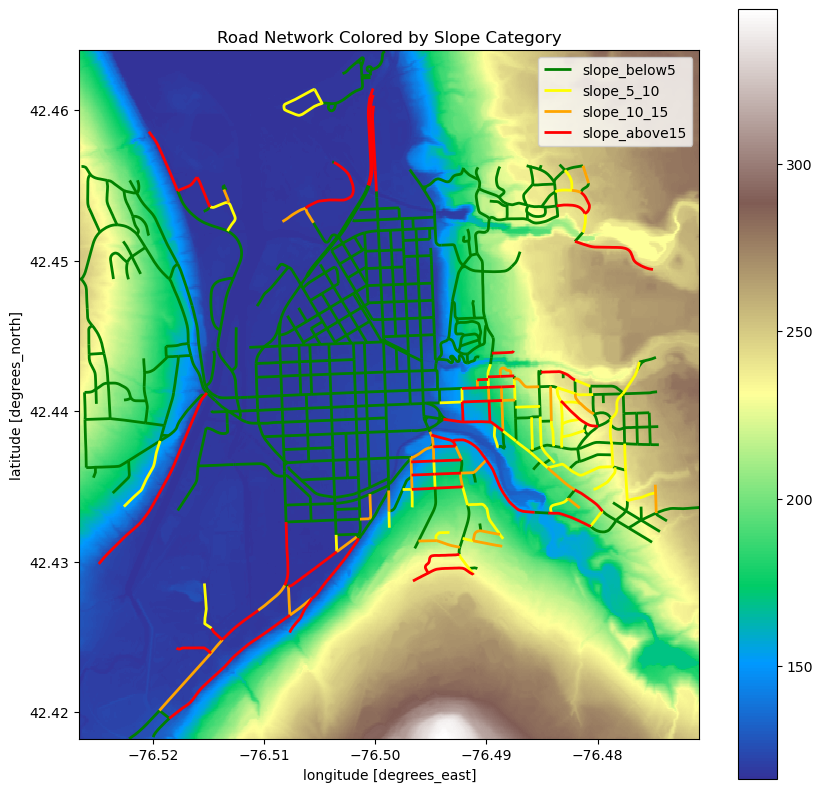

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(10, 10))


dem_clipped.plot(ax=ax, cmap="terrain")


colors = {
    'slope_below5': 'green',
    'slope_5_10': 'yellow',
    'slope_10_15': 'orange',
    'slope_above15': 'red'
}


for col, color in colors.items():
    roads_subset = roads[roads[col] == 1]
    roads_subset.plot(ax=ax, color=color, linewidth=2, label=col)

ax.legend()
ax.set_title("Road Network Colored by Slope Category")
plt.show()